## Calibrating a Classifier using Toy Data

In [1]:
# import libraries

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestClassifier
# for preparation
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# evaluation
from sklearn.metrics import(
    roc_auc_score,
    brier_score_loss,
    roc_curve,
)

# to get the calibrated points
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [2]:
# define a function to prepare toy dataset

def create_data(weights):
    
    X, y = make_classification(n_samples=100000,
                               n_features=20,
                               n_classes=2,
                               n_redundant=10,
                               class_sep=0.8, # how separated the classes are
                               
                               n_informative=2,
                               n_clusters_per_class=1,
                               weights=[weights],  # to balance or not to balance
                               random_state=42)  
    
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    return X,y

In [3]:
# create a balance dataset

X,y  = create_data(0.5)

X.shape, y.shape

((100000, 20), (100000,))

In [4]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.429199,-0.238767,-0.897015,0.549742,1.229739,0.337556,1.183870,-0.670483,1.633881,1.432858,-1.081785,1.385574,-0.004041,-0.894039,-1.500062,0.128965,-2.393856,1.910585,-1.397027,-0.580130
1,0.609187,-0.178715,-0.131053,-0.299957,-0.212216,-0.382546,0.476964,-0.799630,0.788183,1.088158,0.272802,-0.087315,0.527358,1.153215,-0.978695,-0.815755,-1.642886,1.800363,-1.324990,-0.271232
2,-0.179468,-0.076630,-0.973556,0.960215,1.642520,0.045832,0.466935,0.112875,1.003353,0.442593,-1.539779,1.683433,0.509415,0.760956,-0.640172,1.046444,0.726876,1.183733,-0.140631,-1.005396
3,0.498523,-0.216547,0.867658,0.228607,0.685475,-0.498019,-0.516469,-0.721088,1.316846,1.305463,-0.570323,0.829942,1.905509,-1.431049,-1.305786,-0.229230,-1.419213,2.422524,-1.373017,0.038911
4,0.182355,-0.336852,-1.176204,1.821124,3.399519,1.686020,-0.927525,-0.508292,2.944022,1.998439,-3.117074,3.607232,0.698347,-0.903148,-2.328045,1.522666,-1.672095,-0.458659,-1.560419,0.949903


In [5]:
y.value_counts()

1    50029
0    49971
dtype: int64

In [6]:
# split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((70000, 20), (30000, 20))

In [7]:
y_train.value_counts()

0    35109
1    34891
dtype: int64

In [8]:
y_train.value_counts()/len(y_train)

0    0.501557
1    0.498443
dtype: float64

In [9]:
# lets initialize RF model object

rf = RandomForestClassifier(n_estimators=100,
                            max_depth=2,
                            random_state=0,
                            n_jobs=2)

rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, n_jobs=2, random_state=0)

In [11]:
# get the ROC scores

preds_train = rf.predict_proba(X_train)[:,1]
print('ROC score for train data : {}'.format(roc_auc_score(y_train,preds_train)))

preds_test = rf.predict_proba(X_test)[:,1]
print('ROC score for test data : {}'.format(roc_auc_score(y_test,preds_test)))

ROC score for train data : 0.9853218527419859
ROC score for test data : 0.9853796114191993


- We can see that the model performs quite well with both the training and test datasets as given by the roc_auc_score

## Brier Score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [12]:
# get the Brier scores for all models

bs_train = brier_score_loss(y_train,preds_train)
print('Brier score for train data : {}'.format(bs_train))

bs_test = brier_score_loss(y_test,preds_test)
print('Brier score for test data : {}'.format(bs_test))

Brier score for train data : 0.06484877350806174
Brier score for test data : 0.06450635974290052


The brier score also seems to be doing fair. Lets check by plotting the calibration curve

In [22]:
mean_predicted_value

array([0.07999133, 0.12825792, 0.28723052, 0.32675008, 0.4351248 ,
       0.55896979, 0.63467672, 0.76413762, 0.85250514, 0.95812022])

In [24]:
# lets write a function to plot the calibration curve

def plot_calibration_curve(y_test,preds_test,bins):
    
    plt.figure(figsize=(10,14))
    plt.subplot(2,1,1)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, preds_test, n_bins=bins,strategy='uniform')
    plt.plot(mean_predicted_value, fraction_of_positives,label='Random Forest')


    # draw the perfect calibrated line
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),linestyle='--',c='red',label='Perfect Calibration')
    plt.legend(loc='best');
    plt.title('Calibration Curve')
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')

    # lets plot the distribution of the predicted probabilities as well
    plt.subplot(2,1,2)
    plt.hist(preds_test,range=(0,1),bins=bins,density=True,alpha = 0.5)
    plt.title('Density')
    plt.xlabel('')

    plt.show()

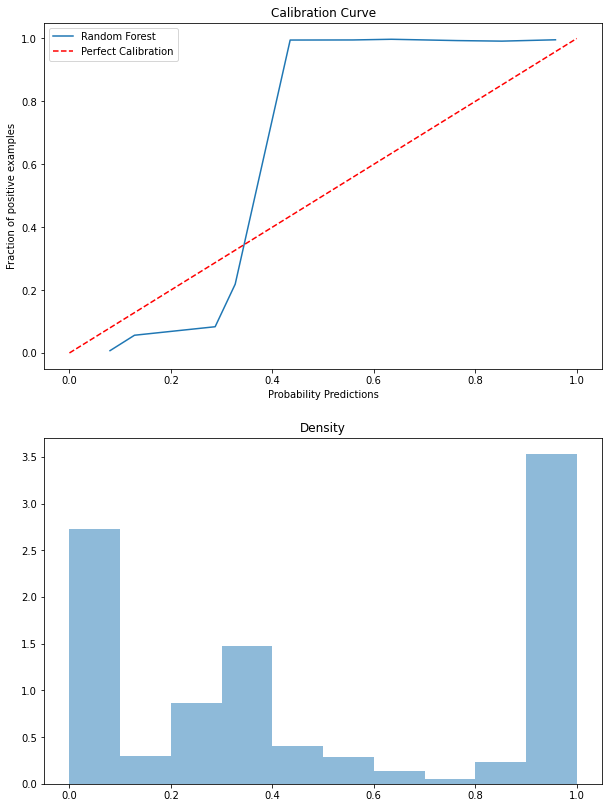

In [25]:
plot_calibration_curve(y_test,preds_test,bins=10)

The probability of the random forests is uncalibrated

## Probability Re-calibration
- Now we'll try to calibrate our rf model predictions

In [26]:
# create a calibrated classifier cv 

# for isotonic method
clf_iso = CalibratedClassifierCV(base_estimator=rf, n_jobs=2, cv=5, method='isotonic')

# fitting the clf to our test data
# its best to keep some hold sample data, but for less data, we can do this method of cv
clf_iso.fit(X_test,y_test) 
# get the predictions
preds_iso = clf_iso.predict_proba(X_test)[:,1]


# for sigmoid method - or platt method
clf_sigmoid = CalibratedClassifierCV(base_estimator=rf, n_jobs=2, cv=5, method='sigmoid')
clf_sigmoid.fit(X_test,y_test) 
# get the predictions
preds_sigmoid = clf_sigmoid.predict_proba(X_test)[:,1]

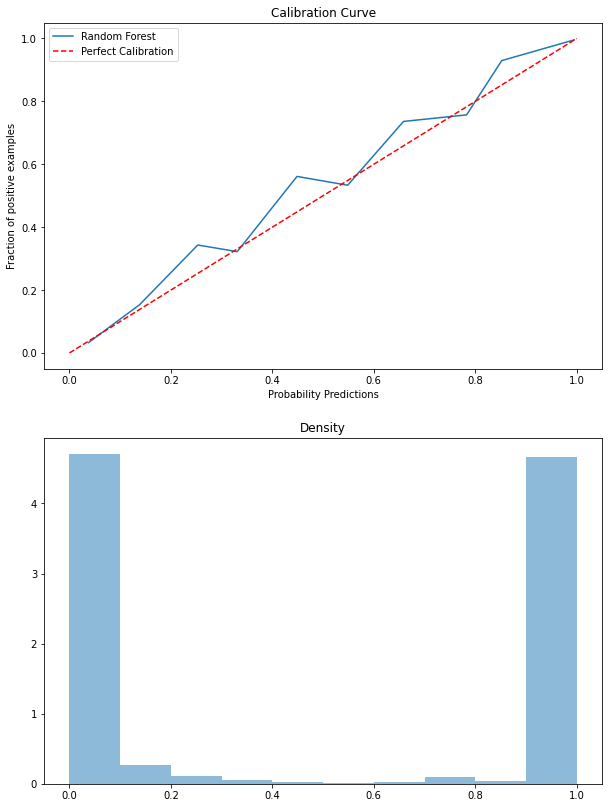

In [27]:
plot_calibration_curve(y_test,preds_iso,bins=10)

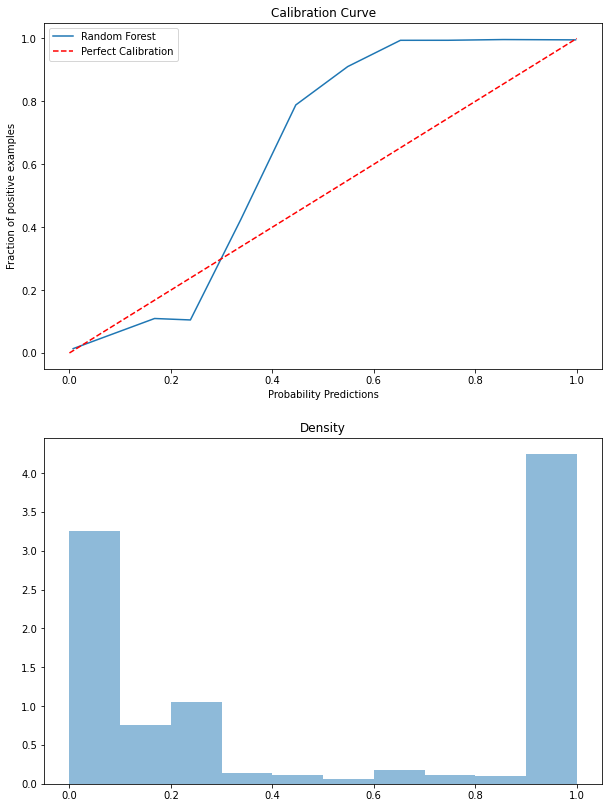

In [28]:
plot_calibration_curve(y_test,preds_sigmoid,bins=10)

For this particular dataset, the Isotonic Calibration worked better than Plat Scaling

In [29]:
# checking the roc score for this classifiers

print('ROC score for test data ISOTONIC: {}'.format(roc_auc_score(y_test,preds_iso)))

ROC score for test data ISOTONIC: 0.9875928209674779


In [30]:
# checking the roc score for this classifiers

print('ROC score for test data SIGMOID: {}'.format(roc_auc_score(y_test,preds_sigmoid)))

ROC score for test data SIGMOID: 0.9866626555716121


In [31]:
# the original score before calibrating
# get the ROC scores

preds_train = rf.predict_proba(X_train)[:,1]
print('ROC score for train data : {}'.format(roc_auc_score(y_train,preds_train)))

preds_test = rf.predict_proba(X_test)[:,1]
print('ROC score for test data : {}'.format(roc_auc_score(y_test,preds_test)))

ROC score for train data : 0.9853218527419859
ROC score for test data : 0.9853796114191993


- Seems the model performance also seems to be better with the calibrated classifier

In [32]:
# checking the brier scores - expecting to be much better

bs_test = brier_score_loss(y_test,preds_iso)
print('Brier score for test data ISOTONIC: {}'.format(bs_test))

Brier score for test data ISOTONIC: 0.02739498834500589


In [33]:
bs_test = brier_score_loss(y_test,preds_sigmoid)
print('Brier score for test data SIGMOID: {}'.format(bs_test))

Brier score for test data SIGMOID: 0.03640891960831679


In [34]:
# BEFORE calibration scores
bs_train = brier_score_loss(y_train,preds_train)
print('Brier score for train data : {}'.format(bs_train))

bs_test = brier_score_loss(y_test,preds_test)
print('Brier score for test data : {}'.format(bs_test))

Brier score for train data : 0.06484877350806174
Brier score for test data : 0.06450635974290052


- As expected, the brier scores for both the methods are pretty much better and improved.